# Markowitz Portfolio Optimization

The objective of this project is to construct a diversified portfolio comprising 11 assets and demonstrate how diversification reduces overall portfolio volatility. The analysis further aims to determine the optimal asset weights that yield the minimum volatility portfolio and the maximum Sharpe ratio portfolio.

In [107]:
# the libraries used in this code

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)

## Data Preparation

The portfolio consists of 11 assets from multiple asset classes, including equities, bond ETFs, REIT ETFs, commodities, and cryptocurrencies. Historical data from 1st January 2018 to 1st January 2025 (a 7-year period) is used to compute daily returns for each asset.

In [291]:
# assets are defined
assets = [
    "SPY", "QQQ", "IWM",     # equities
    "LQD", "IEF", "HYG",     # bonds
    "VNQ",                   # REIT
    "GLD", "USO",            # commodities
    "BTC-USD", "ETH-USD"     # cryptocurrencies
]

# date range
start = "2018-01-01"
end = "2025-01-01"

# adjusted closing prices are downloaded
data = yf.download(assets, start=start, end=end, auto_adjust=True)["Close"]

# daily returns are computed
returns = data.pct_change(fill_method=None).dropna()

[*********************100%***********************]  11 of 11 completed


In [292]:
data

Ticker,BTC-USD,ETH-USD,GLD,HYG,IEF,IWM,LQD,QQQ,SPY,USO,VNQ
Date,,,,,,,,,,,
2018-01-01,13657.200195,772.640991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,14982.099609,884.443970,125.150002,58.052341,88.331787,139.598022,92.094513,150.605377,237.909210,96.559998,61.369087
2018-01-03,15201.000000,962.719971,124.820000,58.331524,88.424179,139.743179,92.262321,152.068756,239.413986,98.720001,61.190926
2018-01-04,15599.200195,980.921997,125.459999,58.431217,88.382179,140.115051,92.231834,152.334824,240.423019,98.959999,60.136799
2018-01-05,17429.500000,997.719971,125.330002,58.471115,88.273064,140.405319,92.201309,153.864655,242.025269,98.480003,60.166508
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,94164.859375,3328.916992,241.399994,75.235634,89.486519,220.654343,103.099487,520.592957,589.841614,73.849998,86.169914
2024-12-28,95163.929688,3397.902344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,93530.226562,3349.513428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [293]:
returns

Ticker,BTC-USD,ETH-USD,GLD,HYG,IEF,IWM,LQD,QQQ,SPY,USO,VNQ
Date,,,,,,,,,,,
2018-01-03,0.014611,0.088503,-0.002637,0.004809,0.001046,0.001040,0.001822,0.009717,0.006325,0.022370,-0.002903
2018-01-04,0.026196,0.018907,0.005127,0.001709,-0.000475,0.002661,-0.000330,0.001750,0.004215,0.002431,-0.017227
2018-01-05,0.117333,0.017125,-0.001036,0.000683,-0.001235,0.002072,-0.000331,0.010043,0.006664,-0.004850,0.000494
2018-01-09,-0.037884,0.131655,-0.004628,-0.003072,-0.004757,-0.001355,-0.003640,0.000061,0.002263,0.015347,-0.012888
2018-01-10,0.025892,-0.033791,0.002405,-0.002169,-0.000287,0.000129,0.000664,-0.002337,-0.001529,0.008751,-0.011192
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,-0.025495,-0.055506,0.001421,-0.001023,-0.004531,-0.004438,-0.005413,-0.004453,-0.000307,-0.004524,-0.015466
2024-12-20,0.002718,0.015982,0.010434,0.006275,0.003685,0.009370,0.003941,0.008732,0.012011,0.006748,0.016847
2024-12-24,0.042138,0.022327,0.001992,0.003190,0.000542,0.008943,0.003094,0.013560,0.011115,0.008076,0.006643


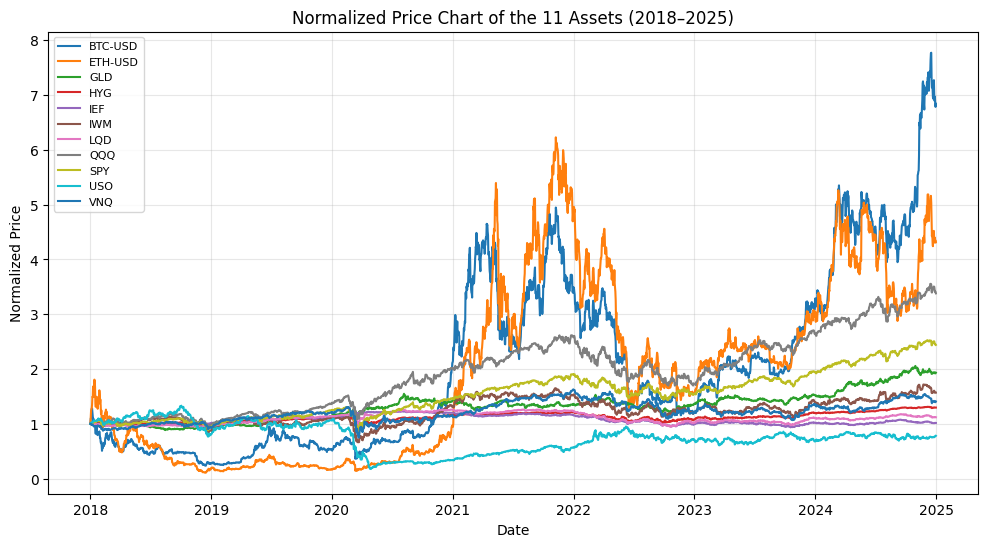

In [294]:
# normalize prices 
price_data = data.bfill()

normalized_prices = price_data / price_data.iloc[0]

# plotting normalized price chart (Data vs Time)
plt.figure(figsize=(12, 6))
for col in normalized_prices.columns:
    plt.plot(normalized_prices.index, normalized_prices[col], label=col)

plt.title("Normalized Price Chart of the 11 Assets (2018–2025)")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()


The normalized price chart of all the assets are plotted above

## Portfolio Creation


Features for both the Linear Regression and Random Forest Regressor models are created using time series data, where each feature set consists of the past 20 daily returns to predict the next (nth) return. A lag of 20 is chosen to capture short-term momentum and mean-reversion behavior in asset returns.

The daily return is converted to annual return by compounding over 252 trading days.

In [295]:
# time series features for modelling
def make_features(series, lag=20):
    X, y = [], []
    for i in range(lag, len(series)-1):
        X.append(series.iloc[i - lag:i].values)
        y.append(series.iloc[i+1])
    return np.array(X), np.array(y)

# annual return is calculated by compounding daily return over 252 days
def annualize_daily_returns(daily_return):
    return ((1 + daily_return) ** 252) - 1

# different asset categories are defined 
rf_assets = ["BTC-USD", "ETH-USD"]                       # crypto (volatile assets) - uses rf
lr_assets = ["SPY", "QQQ", "IWM", "VNQ", "GLD", "USO"]   # stocks, REITs, commodities (relatively non volatile) - uses lr
bond_assets = ["LQD", "IEF", "HYG"]                      # bonds - uses simple average

# daily returns are predicted and expected annual return is stored 
predicted_daily_returns = pd.DataFrame(index=returns.index, columns=assets)
expected_returns = {}

The assets are divided into three categories based on their volatility and behavior. Cryptocurrencies (BTC-USD and ETH-USD), being highly volatile and exhibiting nonlinear patterns, are modeled using a Random Forest Regressor to better capture complex relationships. Equities, REITs, and commodities (SPY, QQQ, IWM, VNQ, GLD, and USO) are relatively more stable and follow linear trends, so a Linear Regression model is used for their return prediction. Bonds (LQD, IEF, and HYG) generally display low volatility and consistent returns; therefore, their expected returns are estimated using the simple average of historical returns rather than a machine learning model.

In [296]:
for asset in assets:
    asset_returns = returns[asset].dropna()
    
    if asset in rf_assets:
        
        # Random Forest Regression
        X, y = make_features(asset_returns, lag=20)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        model = RandomForestRegressor(n_estimators=300, max_depth=8, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # fills predicted daily returns in DataFrame
        predicted_daily_returns.loc[asset_returns.index[-len(y_pred):], asset] = y_pred
        # expected annualized return
        rf_mean_daily = np.mean(y_pred)
        expected_returns[asset] = annualize_daily_returns(rf_mean_daily)
    
    elif asset in lr_assets:
        
        # Linear Regression
        X, y = make_features(asset_returns, lag=20)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # fills predicted daily returns in DataFrame
        predicted_daily_returns.loc[asset_returns.index[-len(y_pred):], asset] = y_pred

        # expected annualized return
        lr_mean_daily = np.mean(y_pred)
        expected_returns[asset] = annualize_daily_returns(lr_mean_daily)
    
    elif asset in bond_assets:
        
        # historical mean
        asset_returns = asset_returns.clip(lower=-0.002, upper=0.002)
        mean_daily = np.mean(asset_returns)
        predicted_daily_returns.loc[asset_returns.index, asset] = asset_returns
        expected_returns[asset] = annualize_daily_returns(mean_daily)

In [297]:
# converts expected returns to pandas series
expected_returns = pd.Series(expected_returns).dropna()

# computes covariance matrix (annualized) 
predicted_daily_returns = predicted_daily_returns.astype(float).fillna(returns) 
cov_daily = predicted_daily_returns.cov()
cov_annual = cov_daily * 252  # annualized

In [298]:
# the expected returns of assets
print("\nPredicted Annualized Returns 2018–2025:\n")
print(expected_returns)


Predicted Annualized Returns 2018–2025:

SPY        0.179319
QQQ        0.256649
IWM        0.120517
LQD        0.042233
IEF        0.018988
HYG        0.047927
VNQ        0.182133
GLD        0.084606
USO        0.217997
BTC-USD    0.343172
ETH-USD    0.673929
dtype: float64


In [299]:
# the covariance matrix
print("\nCovariance Matrix (Annualized) 2023–2025:\n")
print(cov_annual)


Covariance Matrix (Annualized) 2023–2025:

              SPY       QQQ       IWM       LQD       IEF       HYG       VNQ  \
SPY      0.033294  0.038261  0.036039  0.000926 -0.000666  0.002714  0.028778   
QQQ      0.038261  0.050251  0.039472  0.001197 -0.000543  0.003276  0.029273   
IWM      0.036039  0.039472  0.050555  0.000905 -0.000944  0.003160  0.034327   
LQD      0.000926  0.001197  0.000905  0.000753  0.000554  0.000304  0.001437   
IEF     -0.000666 -0.000543 -0.000944  0.000554  0.000739  0.000101  0.000147   
HYG      0.002714  0.003276  0.003160  0.000304  0.000101  0.000676  0.002395   
VNQ      0.028778  0.029273  0.034327  0.001437  0.000147  0.002395  0.041289   
GLD      0.002474  0.003235  0.002515  0.001027  0.001031  0.000466  0.004024   
USO      0.019292  0.017677  0.023433  0.000103 -0.001116  0.001877  0.013629   
BTC-USD  0.032933  0.041069  0.040709  0.001124 -0.000212  0.002505  0.026068   
ETH-USD  0.043253  0.053414  0.051360  0.001503 -0.000155  0.0032

Now since we have the Expected Returns and the Covariance table, we need to find the optimal weights for our portfolio. A Monte Carlo simulation is used for this purpose, where random weight combinations are assigned to the 11 assets and the process is repeated 1,000,000 times. For each simulated portfolio, the expected return is calculated as the dot product of the weight vector and the expected return vector, while the portfolio volatility is obtained from the square root of the quadratic form involving the weights and the covariance matrix -

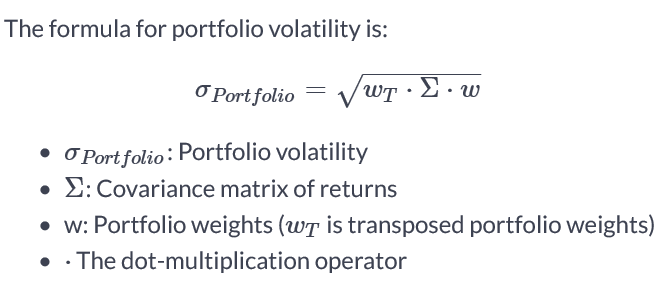

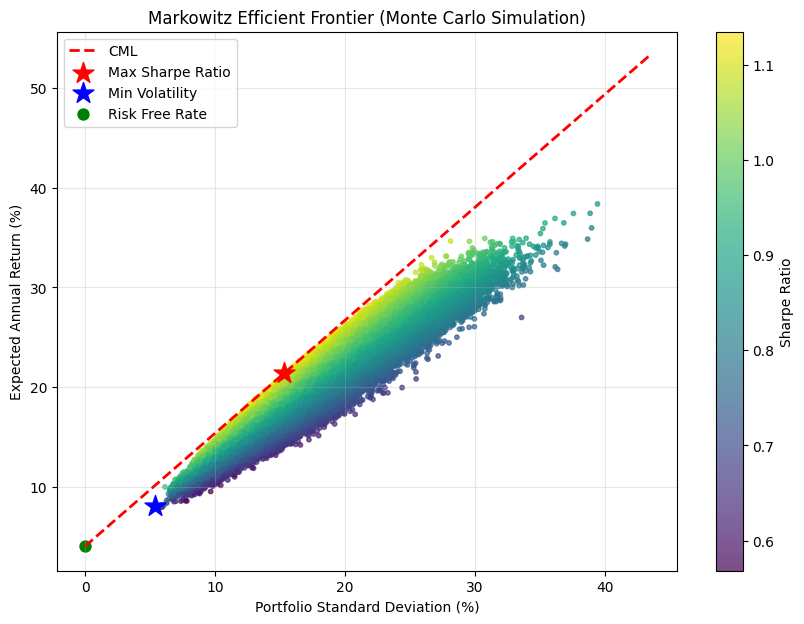


Maximum Sharpe Ratio Portfolio:
Return(%)    21.373765
StdDev(%)    15.297361
Sharpe        1.134429
Name: 696111, dtype: float64

Minimum Volatility Portfolio:
Return(%)    8.026991
StdDev(%)    5.358755
Sharpe       0.747747
Name: 159358, dtype: float64


In [310]:
# monte carlo simulation for markowitz frontier

num_portfolios = 1000000  # number of simulated portfolios

portfolio_returns = []
portfolio_volatility = []
portfolio_weights = []

mu = expected_returns.values
cov = cov_annual.values
n_assets = len(mu)

np.random.seed(42)

for i in range(num_portfolios):
    # random weights that sum to 1
    weights = np.random.random(n_assets)
    weights = weights / np.sum(weights)
    
    # portfolio return and volatility
    port_return = np.dot(weights, mu)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    
    portfolio_returns.append(port_return)
    portfolio_volatility.append(port_vol)
    portfolio_weights.append(weights)

# combining all portfolio results
portfolios = pd.DataFrame({
    "Return": portfolio_returns,
    "Volatility": portfolio_volatility
})

# calculating the sharpe ratio (risk-free rate = 0.0402)
portfolios["Sharpe"] = (portfolios["Return"] - 0.0402) / portfolios["Volatility"]

# identifying the optimal portfolios (make copies to avoid SettingWithCopyWarning)
max_sharpe_port = portfolios.iloc[portfolios["Sharpe"].idxmax()].copy()
min_vol_port = portfolios.iloc[portfolios["Volatility"].idxmin()].copy()

# labelling
portfolios["Return(%)"] = portfolios["Return"] * 100
portfolios["StdDev(%)"] = portfolios["Volatility"] * 100
max_sharpe_port["Return(%)"] = max_sharpe_port["Return"] * 100
max_sharpe_port["StdDev(%)"] = max_sharpe_port["Volatility"] * 100
min_vol_port["Return(%)"] = min_vol_port["Return"] * 100
min_vol_port["StdDev(%)"] = min_vol_port["Volatility"] * 100

# plotting the markowitz frontier (return vs std dev) 
plt.figure(figsize=(10, 7))
plt.scatter(
    portfolios["StdDev(%)"], portfolios["Return(%)"],
    c=portfolios["Sharpe"], cmap="viridis", s=10, alpha=0.7
)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Portfolio Standard Deviation (%)")
plt.ylabel("Expected Annual Return (%)")
plt.title("Markowitz Efficient Frontier (Monte Carlo Simulation)")

# CML line
cml_x = np.linspace(0, max(portfolios["Volatility"])*1.1, 100)
cml_y = rf + max_sharpe_port["Sharpe"] * cml_x
plt.plot(cml_x*100, cml_y*100, color="r", linestyle="--", linewidth=2, label="CML")

# highlighting the optimal portfolios
plt.scatter(
    max_sharpe_port["StdDev(%)"], max_sharpe_port["Return(%)"],
    color="r", marker="*", s=250, label="Max Sharpe Ratio"
)
plt.scatter(
    min_vol_port["StdDev(%)"], min_vol_port["Return(%)"],
    color="b", marker="*", s=250, label="Min Volatility"
)
plt.scatter(
    0, 4.02,
    color="g", marker=".", s=250, label="Risk Free Rate"
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# printing the optimal portfolioty
print("\nMaximum Sharpe Ratio Portfolio:")
print(max_sharpe_port[["Return(%)", "StdDev(%)", "Sharpe"]])

print("\nMinimum Volatility Portfolio:")
print(min_vol_port[["Return(%)", "StdDev(%)", "Sharpe"]])

In [301]:
# getting indices of optimal portfolios 
max_sharpe_index = portfolios["Sharpe"].idxmax()
min_vol_index = portfolios["Volatility"].idxmin()

# retrieving weights 
max_sharpe_weights = portfolio_weights[max_sharpe_index] 
min_vol_weights = portfolio_weights[min_vol_index] 

# converting to pandas series
max_sharpe_weights_series = pd.Series(max_sharpe_weights, index=expected_returns.index)
min_vol_weights_series = pd.Series(min_vol_weights, index=expected_returns.index)

# printing the weights
max_sharpe_weights_series = max_sharpe_weights_series
min_vol_weights_series = min_vol_weights_series

print("\nMaximum Sharpe Ratio Portfolio Weights:\n")
print(max_sharpe_weights_series.round(4))

print("\nMinimum Volatility Portfolio Weights:\n")
print(min_vol_weights_series.round(4))


Maximum Sharpe Ratio Portfolio Weights:

SPY        0.0022
QQQ        0.2880
IWM        0.0113
LQD        0.0352
IEF        0.1044
HYG        0.0580
VNQ        0.0498
GLD        0.1978
USO        0.1351
BTC-USD    0.0093
ETH-USD    0.1089
dtype: float64

Minimum Volatility Portfolio Weights:

SPY        0.0456
QQQ        0.1096
IWM        0.0008
LQD        0.1918
IEF        0.2209
HYG        0.1960
VNQ        0.0078
GLD        0.2187
USO        0.0069
BTC-USD    0.0014
ETH-USD    0.0004
dtype: float64


## Backtesting on Historical Data

Backtesting is performed on historical price data from 1st January 2025 to 1st October 2025 for both the Maximum Sharpe Ratio Portfolio and the Minimum Volatility Portfolio.

In [304]:
tickers = ["SPY", "QQQ", "IWM", "LQD", "IEF", "HYG", "VNQ", "GLD", "USO", "BTC-USD", "ETH-USD"]
start_bt = "2025-01-01"
end_bt = "2025-10-01"

backtest_data = yf.download(tickers, start=start_bt, end=end_bt, auto_adjust=True)["Close"]

backtest_returns = backtest_data.ffill().pct_change(fill_method=None).dropna()

# for maximum sharpe ratio portfolio
weights_1 = max_sharpe_weights

# for minimum volatility portfolio
weights_2 = min_vol_weights

[*********************100%***********************]  11 of 11 completed


### For Maximum Sharpe Ratio Portfolio:

In [308]:
daily_portfolio_returns_1 = backtest_returns.dot(weights_1)

# total cumulative return over the period
cumulative_return_1 = (1 + daily_portfolio_returns_1).prod() - 1

# Number of observations (periods) in the backtest
N_periods = daily_portfolio_returns_1.shape[0]

# Annualize from total cumulative return
annualized_return_1 = (1 + cumulative_return_1) ** (365 / N_periods) - 1

print("Backtest Period:", start_bt, "to", end_bt)
print(f"Cummulative Return(%): {cumulative_return_1 * 100:.2f}%")
print(f"Annualized Return(%): {annualized_return_1 * 100:.2f}%")

Backtest Period: 2025-01-01 to 2025-10-01
Cummulative Return(%): 19.53%
Annualized Return(%): 27.17%


### For Minimum Volatility Portfolio:

In [309]:
daily_portfolio_returns_2 = backtest_returns.dot(weights_2)

# total cumulative return over the period
cumulative_return_2 = (1 + daily_portfolio_returns_2).prod() - 1

# Number of observations (periods) in the backtest
N_periods = daily_portfolio_returns_2.shape[0]

# Annualize from total cumulative return
annualized_return_2 = (1 + cumulative_return_2) ** (365 / N_periods) - 1

print("Backtest Period:", start_bt, "to", end_bt)
print(f"Cummulative Return(%): {cumulative_return_2 * 100:.2f}%")
print(f"Annualized Return(%): {annualized_return_2 * 100:.2f}%")

Backtest Period: 2025-01-01 to 2025-10-01
Cummulative Return(%): 14.83%
Annualized Return(%): 20.47%
